# Meshless Methods: The Galerkin RKPM and MLS class

In this notebook, we're going to examine the different behaviors of different schemes. We're going to use all those kernels we just spat out for every possible combination of methods to solve a few different problems with analytical solutions and examine they're behavior.

In [1]:
import numpy as np
import cornflakes as cf
import scipy.sparse.linalg as splin
from matplotlib import pylab as plt

import husk_rkpm as hr
import util

In [2]:
# Params
gdim = 2
Nside = 25
L = 1.0
params = np.array([1.0])
Ndesired = 8
cutoff = 2*L

Degrees of Freedom live on a mesh of particles, $X$. We need a second set of points, the gauss points $GW$, $GX$. These represent the integration points of a background mesh.

In [3]:
X = cf.PP.init_grid(Nside,Nside, [-L,-L], [2*L,0.0], [0.0,2*L])
# Make the background mesh
GW,GX = util.GaussQuadGrid(Nside-1,Nside-1, 3,3, [-L,-L], 2*L,2*L)
Npt = X.shape[0]
u = np.zeros(Npt)
# Mark the edges
eps = 1.0e-10
boundary = cf.select_nodes(X, lambda a:
                        a[0]<-L+eps or a[0]>L-eps or 
                        a[1]<-L+eps or a[1]>L-eps )
Nbc = len(boundary)
ubc = np.zeros(Nbc)
# Make the graph connecting gauss points to their support
H_pt_gp,r_pt_gp = cf.Graphers.Build_Proximity_Graph_Given_Length(X,Ndesired,cutoff, GX)
SupR = r_pt_gp.max()
r_pt_gp[:] = SupR
H_pt_gp = cf.Graphers.Build_Proximity_Graph_Variable(X,r_pt_gp, GX)

These are the Dofmaps we need. A vector, scalar, and a parameter block. The Gauss/Eval points share these with the DOF nodes because I'm lazy about Vertex numbering. If this were to run in parallel, we would have to make the vertex ids the Gausspoints and Evaluation points not overlap with the DOF nodes.

In [4]:
dm_ptvec = cf.Dofmap_Strided(gdim)
dm_ptsca = cf.Dofmap_Strided(1)
dm_param = cf.Dofmap_Strided(params.size)

The data dictionary for the variational problem.

In [5]:
data = {'x':(X,dm_ptvec),
        'u':(u,dm_ptsca),
        'y':(GX,dm_ptvec), #laziness
        'w':(GW,dm_ptsca),
        'sup':(r_pt_gp,dm_ptsca),
       }

In [6]:
def eval_rkpm(X,u, y, grad=False):
    #H,r = cf.Graphers.Build_Proximity_Graph_Given_Length(X,Ndesired, cutoff , y)
    r = SupR*np.ones(y.shape[0])
    H = cf.Graphers.Build_Proximity_Graph_Variable(X,r, y)
    #H = cf.Graphers.Build_Proximity_Graph_Uniform(X,SupR, y)
    if grad:
        ke = hr.kernel_interp_grad_u
    else:
        ke = hr.kernel_interp_u
    ui, = cf.Assemble(ke, H,
                      {'x':(X,dm_ptvec),
                       'sup':(r,dm_ptsca),
                       'u':(u,dm_ptsca),
                       'y':(y,dm_ptvec)},
                      {'uy':(dm_ptsca,)},
                      ndof=y.shape[0])
    return ui
def eval_shape(X, i, sample=100, grad=False):
    a = np.zeros(X.shape[0])
    a[i] = 1.0
    xprobe = cf.PP.init_grid(sample,sample,[-L,-L],[2*L,0],[0,2*L])
    shapei = eval_rkpm(X,a, xprobe, grad)
    return xprobe,shapei
def eval_rkpm_grid(X, ui, sample=100, grad=False):
    xprobe = cf.PP.init_grid(sample,sample,[-L,-L],[2*L,0],[0,2*L])
    u = eval_rkpm(X,ui, xprobe, grad)
    return xprobe,u

In [7]:
#_x,_u=eval_shape(X,33)
#util.surfplot(_x,_u)
#util.surfplotly(_x,_u)

In [8]:
K,R = cf.Assemble(hr.kernel_poisson_0, H_pt_gp ,
                 data,
                 {'R':(dm_ptsca,),'K':(dm_ptsca,)},
                 ndof=X.shape[0])

In [9]:
cf.Apply_BC(dm_ptsca.Get_List(boundary),-ubc,
            K,R)
Du = splin.spsolve(K,R)
u = u - Du[:Npt]
#plt.spy(K[0:100,0:100])
#plt.show()

In [10]:
_x,_u=eval_rkpm_grid(X,u,sample=500)

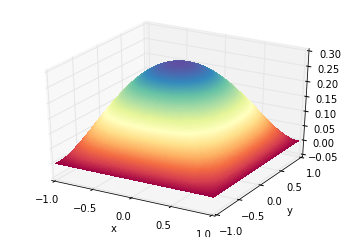

In [11]:
util.surfplot(_x,-_u)

In [12]:
_u.max()

0.00056637539544838913